## Aim
Classify the famous of MNIST dataset using a simple non-convolutional deep neural network (on tensorflow).

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import keras


/anaconda3/envs/deep_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We're using TF 1.10.0


Using TensorFlow backend.


## Preprocessing
### Loading 

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print(f"X_train shape: {X_train.shape}    X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}           y_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)    X_test shape: (10000, 28, 28)
y_train shape: (60000,)           y_test shape: (10000,)


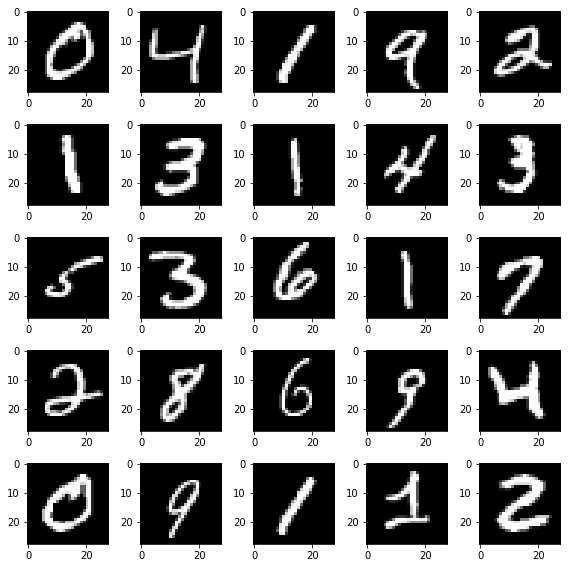

In [3]:
#Looking at the images
fig=plt.figure(figsize=(8,8))
for i in range(1,26):
    img = X_train[i,:]
    fig.add_subplot(5,5,i)
    plt.imshow(img,cmap="gray")

fig.tight_layout()
plt.show()

### Normalize

In [4]:
X_train = X_train.astype(float)/255.
X_test = X_test.astype(float)/255.

### Validation Split

In [5]:
#using the last 10,000 images for validation
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

### Flatten

In [6]:
#Flattening the images so that the can be used in the learning process
X_train = X_train.reshape([X_train.shape[0],-1])
X_val = X_val.reshape([X_val.shape[0],-1])
X_test = X_test.reshape([X_test.shape[0],-1])

### One Hot Encoding


In [7]:
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val,10)
# y_test = keras.utils.to_categorical(y_test,10)

print(f"y_train One hot encoded shape: {y_train.shape}")
print(f"y_val One hot encoded shape: {y_val.shape}")
# print(f"y_test One hot encoded shape: {y_test.shape}")

y_train One hot encoded shape: (50000, 10)
y_val One hot encoded shape: (10000, 10)


## Model
### Create

In [8]:
#Create a new a Tensorflow session
s = tf.InteractiveSession()
regularizer = tf.contrib.layers.l2_regularizer(0.01)

In [9]:
#creating the placeholders for the inputs
input_X = tf.placeholder(tf.float32, shape=(None,784), name='input_X') ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder(tf.float32, shape=(None,10), name='input_y') ### tf.placeholder(...) for one-hot encoded true labels

#creating the hidden layers
hidden1 = tf.layers.dense(input_X, 512, activation=tf.nn.relu, kernel_regularizer=regularizer)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.relu, kernel_regularizer=regularizer)
hidden3 = tf.layers.dense(hidden2, 256, activation=tf.nn.relu, kernel_regularizer=regularizer)

#logits
logits = tf.layers.dense(hidden3, 10)

#output activation function
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,axis=1)

#loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y,logits=logits))+\
tf.losses.get_regularization_loss()
#optimizer
step = tf.train.AdamOptimizer().minimize(loss)

### Train

In [10]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# # for logging the progress right here in Jupyter (for those who don't have TensorBoard)
# simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)
        

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val, input_y: y_val})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val}))  
    if epoch%5 == 0:
        print(f"Training Loss: {train_loss} | Validation Loss: {val_loss}")
        print(f"Training Accuracy: {train_accuracy} | Validation Accuracy: {valid_accuracy}")


#     simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets